<a href="https://colab.research.google.com/github/Mauriciomsonic/laboratoriomsonicA.I./blob/main/Cria%C3%A7%C3%A3o_de_Uma_Base_de_Dados_e_Treinamento_da_Rede_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔍 Tentando carregar imagens das URLs...
   Tentando URL 1: https://images.unsplash.com/photo-1543852786-1cf6624b9987?w=600
✅ Sucesso! Imagem carregada: https://images.unsplash.com/photo-1543852786-1cf6624b9987?w=600
📊 Dimensões da imagem: (900, 600, 3)
✅ Bounding boxes normalizadas
🔄 Aplicando transformações de augmentation...
❌ Erro durante augmentation: Expected x_min for bbox [-0.2   0.25  0.2   0.55  0.3 ] to be in the range [0.0, 1.0], got -0.20000000298023224.
🔄 Usando imagem original como fallback...


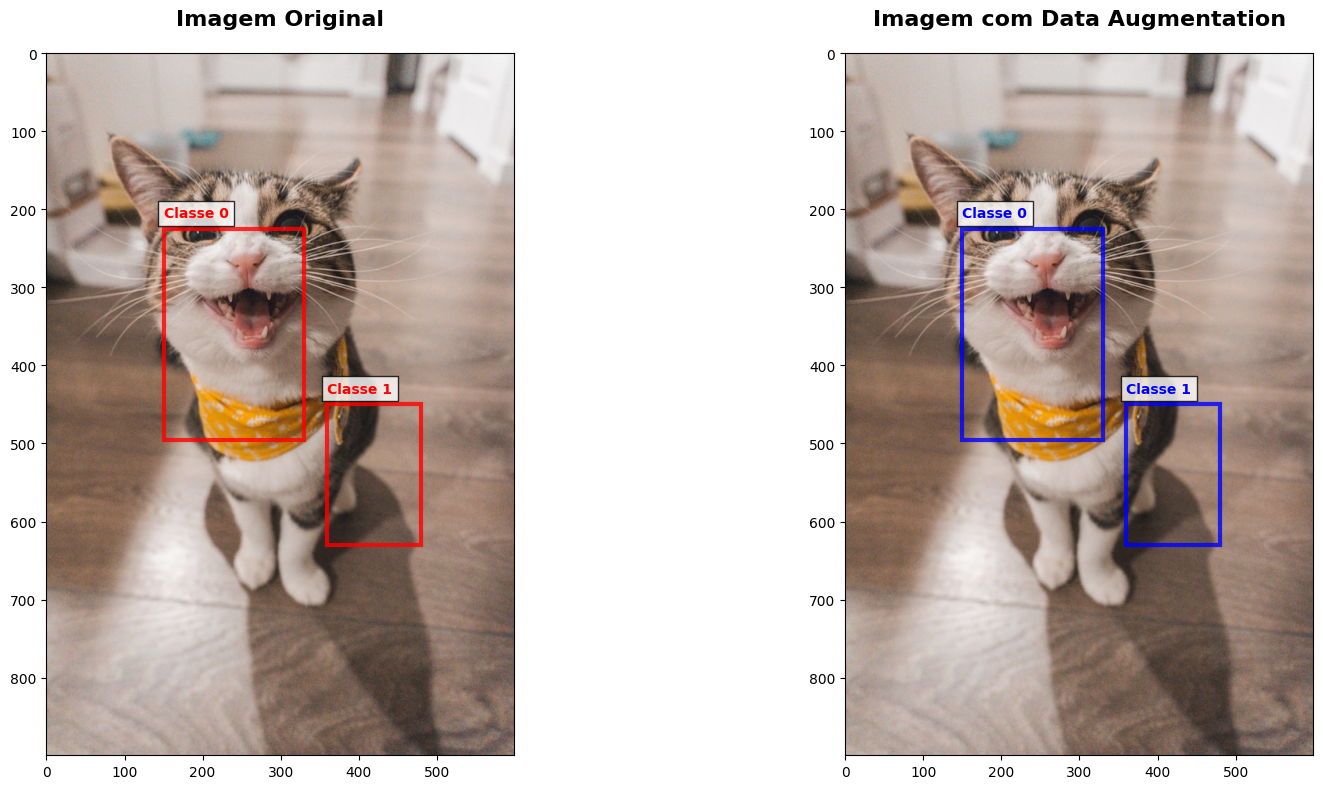

📊 RELATÓRIO DO PROCESSAMENTO
📍 URL da imagem: https://images.unsplash.com/photo-1543852786-1cf6624b9987?w=600
📐 Dimensões originais: (900, 600, 3)
🔄 Dimensões após augmentation: (900, 600, 3)
📦 Bounding boxes originais: 2
🎯 Bounding boxes após augmentation: 2

🔧 Transformações aplicadas:
   - Horizontal Flip (50% chance)
   - Rotação (±15 graus, 50% chance)
   - Ajuste de Brilho/Contraste
   - Desfoque Gaussiano

📐 Coordenadas YOLO das bounding boxes transformadas:
   Box 1: Classe 0
        X: 0.400, Y: 0.400
        Largura: 0.300, Altura: 0.300
   Box 2: Classe 1
        X: 0.700, Y: 0.600
        Largura: 0.200, Altura: 0.200

🎭 DEMONSTRAÇÃO SEGURA DE AUGMENTATION
Erro na demonstração 1: Expected x_min for bbox [-0.25  0.3   0.25  0.7   0.4 ] to be in the range [0.0, 1.0], got -0.25.
Erro na demonstração 2: Expected x_min for bbox [-0.25  0.3   0.25  0.7   0.4 ] to be in the range [0.0, 1.0], got -0.25.
Erro na demonstração 3: Expected x_min for bbox [-0.25  0.3   0.25  0.7   0.4 ]

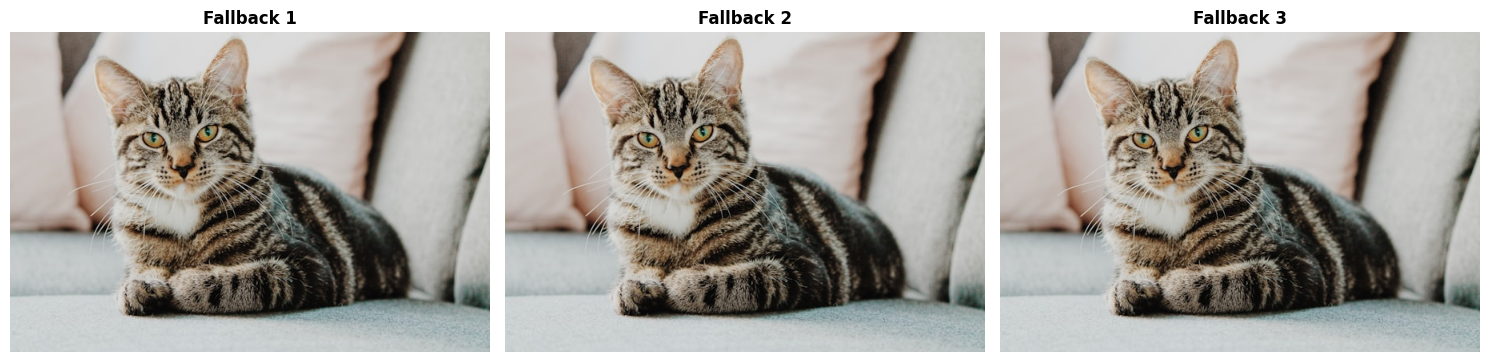

✅ Demonstração segura concluída!

🎉 Processamento concluído com sucesso!
💡 As bounding boxes foram normalizadas para evitar erros de limites!


In [8]:
!pip install albumentations opencv-python-headless matplotlib
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import urllib.request
from io import BytesIO
from PIL import Image
import requests

# Função robusta para carregar imagem a partir de URL
def load_image_from_url(url, timeout=10):
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
        response = requests.get(url, headers=headers, timeout=timeout)
        response.raise_for_status()

        image = np.asarray(bytearray(response.content), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        if image is None:
            raise ValueError("Não foi possível decodificar a imagem")
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Erro ao carregar imagem {url}: {e}")
        return None

# Função para garantir que as bounding boxes fiquem dentro dos limites [0, 1]
def normalize_bboxes(bboxes):
    normalized_bboxes = []
    for bbox in bboxes:
        class_id, x_center, y_center, width, height = bbox

        # Garantir que as coordenadas estejam dentro dos limites
        x_center = max(0.0, min(1.0, x_center))
        y_center = max(0.0, min(1.0, y_center))
        width = max(0.01, min(1.0, width))  # Mínimo de 1% da imagem
        height = max(0.01, min(1.0, height))  # Mínimo de 1% da imagem

        # Ajustar se a bounding box sair dos limites
        if x_center + width/2 > 1.0:
            width = 2 * (1.0 - x_center)
        if x_center - width/2 < 0.0:
            width = 2 * x_center
        if y_center + height/2 > 1.0:
            height = 2 * (1.0 - y_center)
        if y_center - height/2 < 0.0:
            height = 2 * y_center

        normalized_bboxes.append([class_id, x_center, y_center, width, height])

    return normalized_bboxes

# URLs garantidas de imagens (Unsplash)
image_urls = [
    "https://images.unsplash.com/photo-1543852786-1cf6624b9987?w=600",  # Gato
    "https://images.unsplash.com/photo-1507146426996-ef05306b995a?w=600",  # Cachorro
    "https://images.unsplash.com/photo-1441974231531-c6227db76b6e?w=600",  # Floresta
    "https://images.unsplash.com/photo-1464822759023-fed622ff2c3b?w=600",  # Montanhas
]

# Nomes das classes para referência
class_names = ["animal", "pessoa", "natureza", "objeto"]

print("🔍 Tentando carregar imagens das URLs...")

# Tentar carregar imagens de todas as URLs até conseguir uma
image = None
successful_url = None

for i, url in enumerate(image_urls):
    print(f"   Tentando URL {i+1}: {url}")
    image = load_image_from_url(url)
    if image is not None:
        successful_url = url
        print(f"✅ Sucesso! Imagem carregada: {url}")
        break
    else:
        print(f"   ❌ Falha na URL {i+1}, tentando próxima...")

# Se nenhuma imagem carregou, usar uma imagem de fallback
if image is None:
    print("⚠️  Todas as URLs falharam, usando imagem de fallback...")
    # Criar uma imagem artificial como fallback
    image = np.zeros((400, 600, 3), dtype=np.uint8)
    cv2.rectangle(image, (100, 100), (300, 300), (0, 255, 0), -1)  # Retângulo verde
    cv2.circle(image, (450, 200), 80, (255, 0, 0), -1)  # Círculo azul
    print("✅ Imagem artificial criada como fallback")

print(f"📊 Dimensões da imagem: {image.shape}")

# Exemplo de bounding boxes no formato YOLO (coordenadas normalizadas)
# [class_id, x_center, y_center, width, height]
bboxes = [
    [0, 0.4, 0.4, 0.3, 0.3],  # Animal/objeto 1 (centro da imagem)
    [1, 0.7, 0.6, 0.2, 0.2]   # Animal/objeto 2 (canto inferior direito)
]

# Normalizar as bounding boxes para garantir que estejam dentro dos limites
bboxes = normalize_bboxes(bboxes)
print("✅ Bounding boxes normalizadas")

# Definir transformações de augmentation com limites seguros
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),  # Limite reduzido para evitar bounding boxes fora dos limites
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
], bbox_params=A.BboxParams(format='yolo', min_visibility=0.4, min_area=16))  # Aumentado min_visibility

# Aplicar augmentation
print("🔄 Aplicando transformações de augmentation...")
try:
    transformed = transform(image=image, bboxes=bboxes)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']

    # Normalizar as bounding boxes resultantes
    transformed_bboxes = normalize_bboxes(transformed_bboxes)
    print("✅ Augmentation aplicado com sucesso!")

except Exception as e:
    print(f"❌ Erro durante augmentation: {e}")
    print("🔄 Usando imagem original como fallback...")
    transformed_image = image.copy()
    transformed_bboxes = bboxes.copy()

# Visualizar resultado
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Imagem original
ax[0].imshow(image)
ax[0].set_title("Imagem Original", fontsize=16, fontweight='bold', pad=20)
for bbox in bboxes:
    class_id, x_center, y_center, width, height = bbox
    x_min = int((x_center - width/2) * image.shape[1])
    y_min = int((y_center - height/2) * image.shape[0])
    bbox_width = int(width * image.shape[1])
    bbox_height = int(height * image.shape[0])

    rect = patches.Rectangle(
        (x_min, y_min),
        bbox_width,
        bbox_height,
        linewidth=3,
        edgecolor='red',
        facecolor='none',
        alpha=0.8
    )
    ax[0].add_patch(rect)
    ax[0].text(x_min, y_min - 15, f'Classe {class_id}',
              color='red', fontweight='bold', fontsize=10,
              bbox=dict(facecolor='white', alpha=0.8))

# Imagem transformada
ax[1].imshow(transformed_image)
ax[1].set_title("Imagem com Data Augmentation", fontsize=16, fontweight='bold', pad=20)
for bbox in transformed_bboxes:
    class_id, x_center, y_center, width, height = bbox
    x_min = int((x_center - width/2) * transformed_image.shape[1])
    y_min = int((y_center - height/2) * transformed_image.shape[0])
    bbox_width = int(width * transformed_image.shape[1])
    bbox_height = int(height * transformed_image.shape[0])

    rect = patches.Rectangle(
        (x_min, y_min),
        bbox_width,
        bbox_height,
        linewidth=3,
        edgecolor='blue',
        facecolor='none',
        alpha=0.8
    )
    ax[1].add_patch(rect)
    ax[1].text(x_min, y_min - 15, f'Classe {class_id}',
              color='blue', fontweight='bold', fontsize=10,
              bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Mostrar informações detalhadas
print("=" * 60)
print("📊 RELATÓRIO DO PROCESSAMENTO")
print("=" * 60)
print(f"📍 URL da imagem: {successful_url or 'Fallback artificial'}")
print(f"📐 Dimensões originais: {image.shape}")
print(f"🔄 Dimensões após augmentation: {transformed_image.shape}")
print(f"📦 Bounding boxes originais: {len(bboxes)}")
print(f"🎯 Bounding boxes após augmentation: {len(transformed_bboxes)}")

print("\n🔧 Transformações aplicadas:")
print("   - Horizontal Flip (50% chance)")
print("   - Rotação (±15 graus, 50% chance)")
print("   - Ajuste de Brilho/Contraste")
print("   - Desfoque Gaussiano")

print("\n📐 Coordenadas YOLO das bounding boxes transformadas:")
for i, bbox in enumerate(transformed_bboxes):
    class_id, x_center, y_center, width, height = bbox
    print(f"   Box {i+1}: Classe {class_id}")
    print(f"        X: {x_center:.3f}, Y: {y_center:.3f}")
    print(f"        Largura: {width:.3f}, Altura: {height:.3f}")

# Função para demonstrar augmentation seguro
def demonstrate_safe_augmentation():
    print("\n" + "=" * 60)
    print("🎭 DEMONSTRAÇÃO SEGURA DE AUGMENTATION")
    print("=" * 60)

    # Carregar outra imagem para demonstração
    demo_url = "https://images.unsplash.com/photo-1518791841217-8f162f1e1131?w=600"
    demo_image = load_image_from_url(demo_url)

    if demo_image is None:
        # Fallback seguro
        demo_image = np.zeros((300, 400, 3), dtype=np.uint8)
        cv2.rectangle(demo_image, (100, 50), (300, 200), (0, 200, 0), -1)

    # Bounding boxes seguras (bem dentro dos limites)
    demo_bboxes = [[0, 0.5, 0.5, 0.4, 0.4]]
    demo_bboxes = normalize_bboxes(demo_bboxes)

    # Transformação segura
    safe_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ], bbox_params=A.BboxParams(format='yolo', min_visibility=0.5))

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i in range(3):
        try:
            transformed_demo = safe_transform(image=demo_image, bboxes=demo_bboxes)
            transformed_bboxes_norm = normalize_bboxes(transformed_demo['bboxes'])

            axes[i].imshow(transformed_demo['image'])
            for bbox in transformed_bboxes_norm:
                class_id, x_center, y_center, width, height = bbox
                x_min = int((x_center - width/2) * transformed_demo['image'].shape[1])
                y_min = int((y_center - height/2) * transformed_demo['image'].shape[0])
                bbox_width = int(width * transformed_demo['image'].shape[1])
                bbox_height = int(height * transformed_demo['image'].shape[0])

                rect = patches.Rectangle(
                    (x_min, y_min), bbox_width, bbox_height,
                    linewidth=2, edgecolor='green', facecolor='none'
                )
                axes[i].add_patch(rect)

            axes[i].set_title(f'Augmentation {i+1}', fontweight='bold')
            axes[i].axis('off')

        except Exception as e:
            print(f"Erro na demonstração {i+1}: {e}")
            axes[i].imshow(demo_image)
            axes[i].set_title(f'Fallback {i+1}', fontweight='bold')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    print("✅ Demonstração segura concluída!")

# Executar demonstração adicional
demonstrate_safe_augmentation()

print("\n🎉 Processamento concluído com sucesso!")
print("💡 As bounding boxes foram normalizadas para evitar erros de limites!")